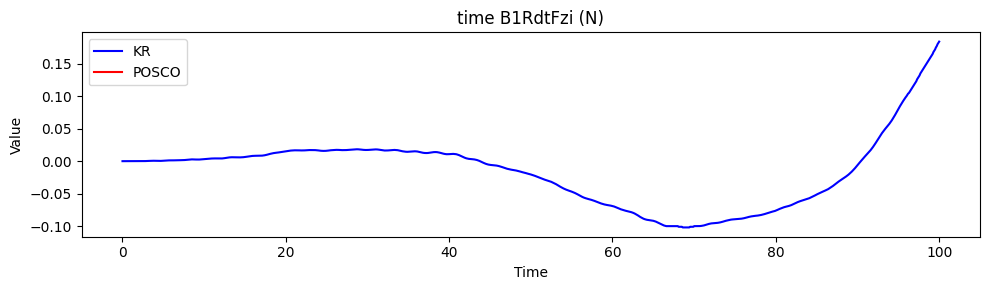

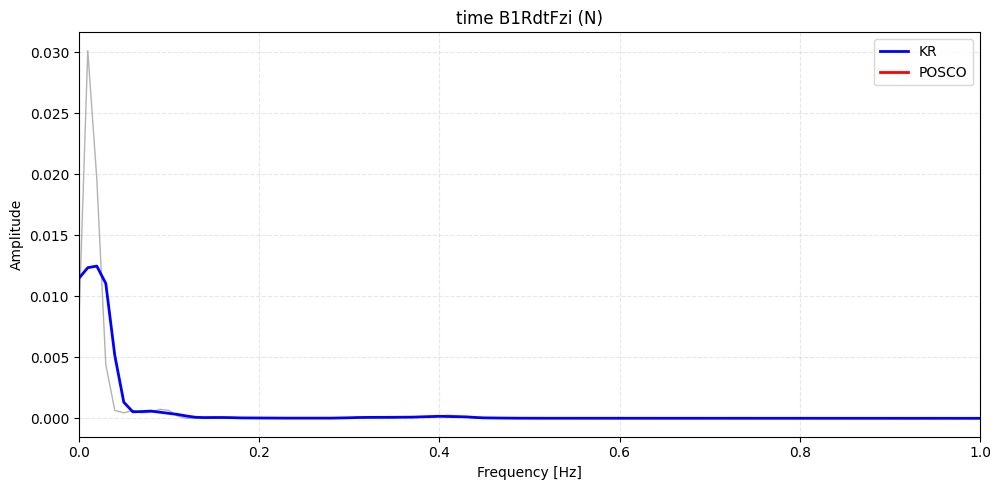

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# 0) ASCII 파일 로더 (두 열: time, value)
# -------------------------------
def load_time_value_from_ascii(path, encoding="utf-8", resample_if_irregular=True, tolerance_ratio=0.01):
    """
    텍스트(ASCII) 파일에서 (time, value) 두 열을 파싱하여 반환합니다.
    - 다양한 구분자(공백/탭/쉼표/세미콜론) 허용
    - 헤더/주석/비수치 라인은 자동 건너뜀
    - time, value 가 둘 다 수치로 파싱된 라인만 채택    
    

    반환:
      t (np.ndarray), y (np.ndarray), fs (float), info (dict)
    """
    t_list, y1_list, y2_list = [], [], []
    with open(path, "r", encoding=encoding, errors="ignore") as f:
        for raw in f:
            line = raw.strip()
            if not line:
                continue
            # 줄 전체가 주석인 경우 스킵
            if line.startswith("#") or line.lower().startswith("time"):
                toks = re.split(r"[,\t; ]+", line)
                title = line
                continue
            # 공백/탭/쉼표/세미콜론 기반 split
            toks = re.split(r"[,\t; ]+", line)
            if len(toks) < 2:
                continue

            # 두 값이 모두 숫자인 경우만 채택
            try:
                a = toks[0]
                b = toks[1]
                c = toks[2] if len(toks) > 2 else None

                tt = float(a)
                v1 = float(b)
                v2 = float(c) if c is not None else None
            except (ValueError, IndexError):
                continue


            t_list.append(tt)
            y1_list.append(v1)
            y2_list.append(v2)

    if len(t_list) < 3:
        raise ValueError("유효한 (time, value) 데이터가 3개 미만입니다. 파일 형식을 확인하세요.")

    t = np.asarray(t_list, dtype=float)
    y1 = np.asarray(y1_list, dtype=float)
    y2 = np.asarray(y2_list, dtype=float)

    # 시간 정렬(필요 시)
    if not np.all(np.diff(t) >= 0):
        idx = np.argsort(t)
        t = t[idx]
        y1 = y1[idx]
        y2 = y2[idx]

    #plot 
    plt.figure(figsize=(10, 3))
    plt.plot(t, y1, linestyle='-', color='blue', label='KR')
    plt.plot(t, y2, linestyle='-', color='red', label='POSCO')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend(loc="best")
    plt.title(title)
    plt.tight_layout()
    plt.show()

    # 샘플링 특성 추정
    fs, is_uniform, dt_med, dt_std = infer_fs_from_time(t, tolerance_ratio=tolerance_ratio)

    info = {
        "is_uniform": bool(is_uniform),
        "dt_med": float(dt_med),
        "dt_std": float(dt_std),
        "fs_estimated": float(fs),
        "n_samples": int(len(t)),
        "title": title if 'title' in locals() else "",
    }

    return t, y1, y2, fs, info


# -------------------------------
# # 1) 유틸: 샘플링 주파수 추정 및 균등 샘플링 검증
# # -------------------------------
def infer_fs_from_time(t, tolerance_ratio=0.01):
    """
    time 배열(초 단위 가정)에서 샘플링 주파수 fs를 추정.
    시간 간격의 변동성이 tolerance_ratio(기본 1%)보다 크면 불균일로 판정.
    """
    t = np.asarray(t)
    dt = np.diff(t)
    dt_med = np.median(dt)
    dt_std = np.std(dt)
    fs = 1.0 / dt_med
    is_uniform = (dt_std / dt_med) < tolerance_ratio
    return fs, is_uniform, dt_med, dt_std


# -------------------------------
# 2) FFT 스펙트럼 (one-sided amplitude spectrum)
# -------------------------------
def fft_amplitude_spectrum(y, fs, window='hann', detrend=True, to_db=False):
    """
    실수 시계열 y에 대해 one-sided amplitude spectrum 계산.
    - fs: 샘플링 주파수 [Hz]
    - window: 'hann' 또는 None
    - detrend: 평균 제거(DC 오프셋 제거)
    - to_db: True면 20*log10(|A|)로 반환
    반환: f(Hz), A (선형 또는 dB)
    """
    y = np.asarray(y).astype(float)
    N = len(y)
    if detrend:
        y = y - np.mean(y)

    # 윈도우
    if window == 'hann':
        w = np.hanning(N)
    else:
        w = np.ones(N)
    yw = y * w

    # FFT (rfft: 실수 신호 -> one-sided)
    Y = np.fft.rfft(yw)
    f = np.fft.rfftfreq(N, d=1.0/fs)

    # one-sided amplitude 정규화
    A = np.abs(Y) / N
    if N % 2 == 0:
        if len(A) > 2:
            A[1:-1] *= 2.0
    else:
        if len(A) > 1:
            A[1:] *= 2.0

    if to_db:
        eps = 1e-20
        A = 20.0 * np.log10(A + eps)

    return f, A


# -------------------------------
# 3) 스무딩(이동평균 / Savitzky–Golay)
# -------------------------------
def moving_average(x, window_bins=11):
    window_bins = int(max(1, window_bins))
    kernel = np.ones(window_bins) / window_bins
    return np.convolve(x, kernel, mode='same')


def smooth_spectrum(f, spec, method='ma', window_bins=11, width_hz=None, savgol_poly=3):
    f = np.asarray(f)
    spec = np.asarray(spec)
    if len(f) > 1:
        df = np.median(np.diff(f))
    else:
        df = None

    if width_hz is not None and df is not None and df > 0:
        window_bins = int(np.clip(round(width_hz / df), 1, len(spec)//2 * 2 + 1))

    if window_bins % 2 == 0:
        window_bins += 1

    spec_smooth = moving_average(spec, window_bins=window_bins)
    
    return spec_smooth

# -------------------------------
# 4) 전체 파이프라인 함수
# -------------------------------
def compute_and_plot_spectrum(y1, y2, fs,
                              smooth_method='ma',
                              smooth_window_bins=21,
                              smooth_width_hz=None,
                              window='hann',
                              detrend=True,
                              title="Amplitude Spectrum",
                              savefig=None):
    f, A1 = fft_amplitude_spectrum(y1, fs=fs, window=window, detrend=detrend)
    A_s1 = smooth_spectrum(f, A1, method=smooth_method,
                          window_bins=smooth_window_bins,
                          width_hz=smooth_width_hz)
    f, A2 = fft_amplitude_spectrum(y2, fs=fs, window=window, detrend=detrend)
    A_s2 = smooth_spectrum(f, A2, method=smooth_method,
                          window_bins=smooth_window_bins,
                          width_hz=smooth_width_hz)

    plt.figure(figsize=(10, 5))
    plt.plot(f, A1, color="gray", alpha=0.6, lw=1.0)
    plt.plot(f, A2, color="gray", alpha=0.6, lw=1.0 )
    plt.plot(f, A_s1, color="blue", lw=2.0, label=f"KR")
    plt.plot(f, A_s2, color="red", lw=2.0, label=f"POSCO") 
    plt.ylabel("Amplitude")
    plt.xlabel("Frequency [Hz]")
    plt.title(title)
    plt.grid(True, which='both', ls='--', alpha=0.3)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.xlim(0,1)  #주파수 범위 조정 가능
    if savefig:
        plt.savefig(savefig, dpi=200)
    plt.show()

    return f, A, A_s

# -------------------------------
# 5) 실행 예시
# -------------------------------
if __name__ == "__main__":
    # 1) ASCII 파일에서 읽기
    ascii_path = "your_data_kr.txt"   # <-- 여기만 바꾸세요 (질문 예시 형식의 파일 경로)
    t, y1, y2, fs, info = load_time_value_from_ascii(
        ascii_path,
        encoding="utf-8",          # 필요 시 파일 인코딩에 맞게 변경        
        resample_if_irregular=True,  # 비균등 샘플링이면 등간격 재표본화 수행
        tolerance_ratio=0.01
    )
    #print("[파일 정보]", info)

    # 2) FFT + 스무딩 + 플롯

    f, A, A_s = compute_and_plot_spectrum(
        y1,y2, fs=fs,
        smooth_method='ma',
        smooth_width_hz=0.05,   
        window='hann', detrend=True, title = info["title"] 
    )
